<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/epat/Assignment_Statistical_Arbitrage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Instructions
<i>You can run the notebook document sequentially (one cell a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

# Assignment

In this assignment, you will learn to interpret the ADF test results and create a mean reversion strategy on triplets.

The steps followed are
1. Import the libraries and the data
2. Find the hedge ratio
3. Create the spread
4. ADF Test
5. Mean reversion strategy
6. Plot the profit and loss (PnL)


## 1. Import the libraries and the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

The code reads the csv file using the read_csv function

Instruction:
1. Replace the `...` with `GLD.csv`, `GDX.csv` and `USO.csv` in the below cell

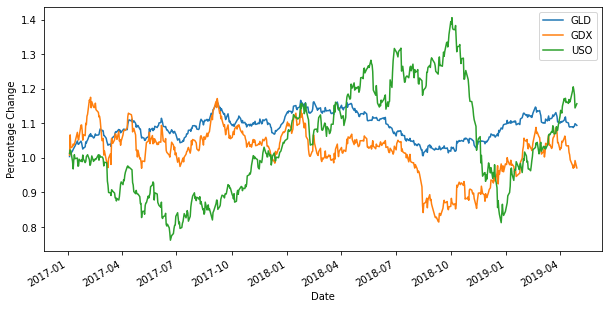

In [3]:
x = pd.read_csv('GLD.csv', index_col=0)['Adj Close']
y = pd.read_csv('GDX.csv', index_col=0)['Adj Close']
z = pd.read_csv('USO.csv', index_col=0)['Adj Close']

df = pd.concat([x, y, z], axis=1)
df.columns = ['GLD', 'GDX', 'USO']
df.index = pd.to_datetime(df.index)

(df.pct_change()+1).cumprod().plot(figsize=(10, 5))
plt.ylabel("Percentage Change")
plt.show()

## 2. Find the hedge ratio

Instructions
1. y is GLD and x1 is GDX and x2 is USO. Replace `..1..` with `GLD`, `..2..` with `GDX`, and `..3..` with `USO`.
2. To find the hedge ratio, we will only use first 90 days of data. Replace `..4..` and `..5..` with `90`.

In [4]:
from statsmodels.api import OLS
model = OLS(df['GLD'].iloc[:90], df[['GDX', 'USO']].iloc[:90])
model = model.fit()
print('The hedge ratio for GDX and USO are')
model.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The hedge ratio for GDX and USO are


GDX    4.783232
USO    0.727756
dtype: float64

## 3. Create the spread

The spread is formed as GLD - m1 * GDX - m2 * USO. The `model.params[0]` stores m1 and `model.params[1]` stores m2.

Instruction
1. Compute the spread

In [6]:
df['spread'] = df['GLD']-model.params[0]*df['GDX']-model.params[1]*df['USO']

The spread is: GLD - 4.783232 * GDX - 0.727756 * USO


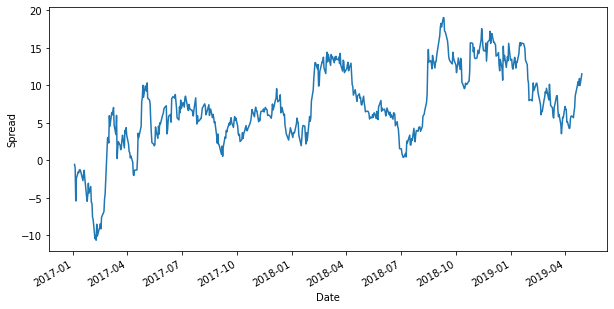

In [7]:
print('The spread is: GLD - %f * GDX - %f * USO' %
      (model.params[0], model.params[1]))
# Plot the spread
df.spread.plot(figsize=(10, 5))
plt.ylabel("Spread")
plt.show()

### 4. ADF Test

We determine the spread is cointegrated using adfuller method.

Instruction

1. Run ADF Test on `df.spread` and with `maxlag` as `1`.

In [8]:
# To perform ADF Test
from statsmodels.tsa.stattools import adfuller
# Compute ADF test statistics
adf = adfuller(df.spread)
adf[0]

-2.6162761499418745

In [15]:
adf[4]

{'1%': -3.441834071558759,
 '10%': -2.569468095872659,
 '5%': -2.8666061267054626}

If t-stat value is less than the critical value then the spread is cointegrated.

Instructions
2. Replace `..2..` with `True` if the spread is cointegrated and `False` if the spread is not cointegrated
(Assume 90% confidence level)

In [ ]:
is_triplet_cointegrated = True

## 5. Mean reversion strategy

In [17]:
def stat_arb(df, lookback, std_dev):
    df['moving_average'] = df.spread.rolling(lookback).mean()
    df['moving_std_dev'] = df.spread.rolling(lookback).std()

    df['upper_band'] = df.moving_average + std_dev*df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev*df.moving_std_dev

    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    df['positions'] = df.positions_long + df.positions_short

    df['spread_difference'] = df.spread - df.spread.shift(1)
    df['pnl'] = df.positions.shift(1) * df.spread_difference
    df['cumpnl'] = df.pnl.cumsum()
    return df

Instruction
1. Call the function stat_arb with df, lookback as 15 and standard deviation as 1.

In [18]:
df = stat_arb(df, 15, 1)

## 6. Plot the profit and loss (PnL)

Instruction
1. Plot the cumulative PnL

In [53]:
df['percentage_change'] = (df.spread - df.spread.shift(1))/(df.GLD+model.params[0]*df.GDX + model.params[1]*df.USO)
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
print('The total strategy returns are :',round((df['cumulative_returns'].iloc[-1]-1)*100,2))

The total strategy returns are : 5.06


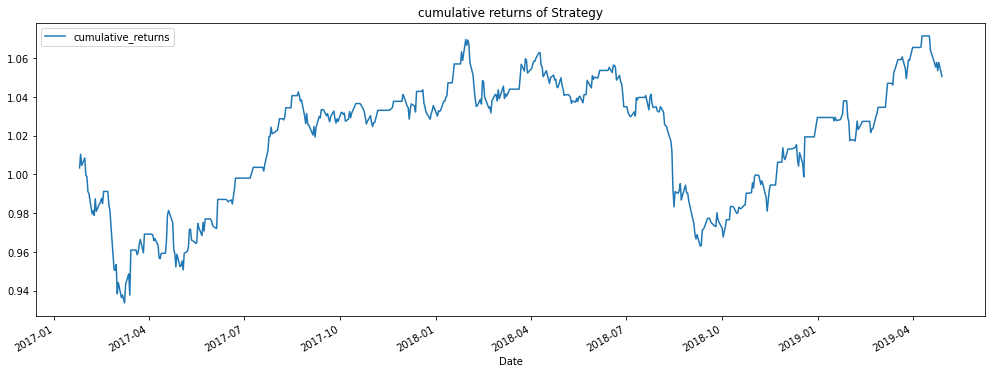

In [58]:
df['cumulative_returns'].plot(kind='line',figsize=(17,6),title='Cumulative Returns of Strategy',legend=True);